# Investigating Gender Bias In Letter of Recommendations

In [23]:
# Libraries to import
import pandas as pd
import spacy
import gender_guesser.detector as gender
import matplotlib.pyplot as plt
from collections import defaultdict
import sentiment_score as sentiment
import seaborn as sns
from scipy.stats import ttest_ind

In [2]:
nlp = spacy.load("en_core_web_sm")
gender_detector = gender.Detector()

In [3]:
def contains_pronouns(text, pronouns):
    words = text.lower().split()
    return any(pronoun in words for pronoun in pronouns)

def anonymize(text):
    if contains_pronouns(text, {'she', 'her'}):
        gender = 'female'
    elif contains_pronouns(text, {'he', 'him'}):
        gender = 'male'
    else :
        gender = 'unknown'
    doc = nlp(text)

    for ent in doc.ents:
        # Check if the entity is a person
        if ent.label_ == "PERSON":
            if gender == 'female':
                text = text.replace(ent.text, "Jane Doe")
            elif gender == 'male':
                text = text.replace(ent.text, "John Doe")
            else:
                text = text.replace(ent.text, "Jane Doe" if gender_detector.get_gender(ent.text)=='female' else "John Doe")
    return text


In [4]:
df =  pd.read_excel("df_all_data_foreign_included.xlsx")

In [5]:
# Replace weird characters and new lines with space

for col in ['lor1', 'lor2', 'lor3', 'lor4', 'medical_school', 'residency_school']:
    df[col] = df[col].str.replace('\n', ' ', regex=False)
    df[col] = df[col].str.lower()
    df[col] = df[col].str.strip()
    df[col] = df[col].str.replace(r"\s+",(r" "))
    df[col] = df[col].str.replace(r"[^\w\s]",(r""))
    df[col] = df[col].str.replace(r"\s+",(r" "))
    df[col] = df[col].str.strip()

# Fix years being float

for col in ['application_year', 'md_year', 'residency_year', 'number_of_publications']:
    try:
        df[col] = df[col].astype('Int64')
    except:
        continue



In [6]:
# Remove unnecessary columns
df = df[['applicant_id', 'application_year',
       'birth_year', 'citizenship', 'medical_school', 'residency_school',
       'md_year', 'residency_year', 'step1', 'step2', 'step3', 'step_old',
       'IMG', 'class_rank', 'honors', 'received_offer', 'language_skills',
       'interests', 'number_of_publications', 'speciality', 'gender', 'lor1',
       'lor1_position', 'lor1_university', 'lor1_gender', 'lor2',
       'lor2_position', 'lor2_university', 'lor2_gender', 'lor3',
       'lor3_position', 'lor3_university', 'lor3_gender', 'lor4',
       'lor4_position', 'lor4_university', 'lor4_gender', 'foreign']]

# Fix some problems with gender typing
df.gender = df.gender.str.strip()



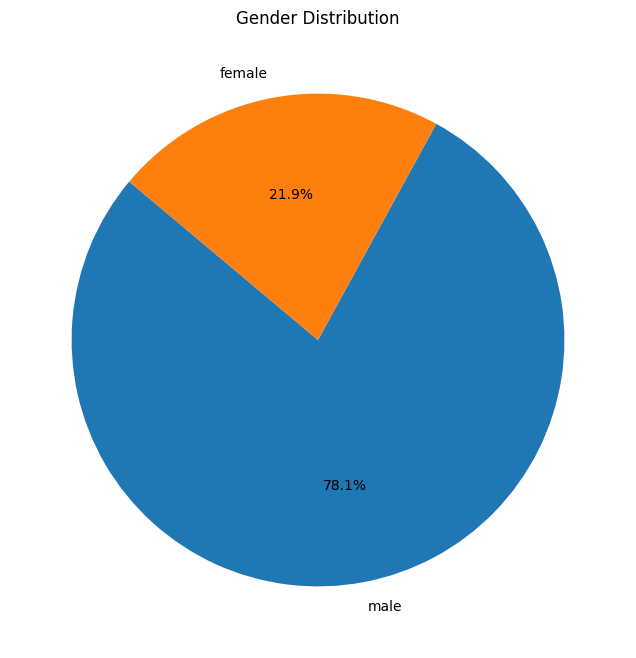

In [7]:
# Gender Counts
gender_counts = df.gender.value_counts()
plt.figure(figsize=(8, 8))  # Optional: Specifies the figure size
plt.pie(gender_counts, labels=gender_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Gender Distribution')
plt.show()


In [15]:
# Making the master DataFrame with each row a new letter

applicant_columns = ['applicant_id', 'application_year', 'birth_year', 'citizenship',"foreign",
       'medical_school', 'residency_school', 'md_year', 'residency_year',
       'step1', 'step2', 'step3', 'step_old', 'IMG', 'class_rank', 'honors',
       'received_offer', 'language_skills', 'interests',
       'number_of_publications', 'speciality', 'gender']
master_dict = defaultdict(list)
for inx,row in df.iterrows():
    for lor in ["lor1","lor2","lor3","lor4"]:
        for column in applicant_columns:
            master_dict[column].append(row[column])
        master_dict["lor"].append(row[lor])
        master_dict["lor_position"].append(row[lor + "_position"])
        master_dict["lor_university"].append(row[lor + "_university"])
        master_dict["lor_gender"].append(row[lor + "_gender"])
        master_dict["lor_number"].append(lor)
df_master = pd.DataFrame(master_dict)
df_master = df_master[df_master['lor'].notna() & (df_master['lor'] != '')]
df_master= df_master.reset_index()
df_master['letter_id'] = df_master.index

In [9]:
# Anonymize letters (takes about 1 min)
df_master['lor'] = df_master['lor'].apply(anonymize)

## Start Analysis

In [19]:
# Calculate sentiment score (takes about 35 mins)

df_master = sentiment.get_sentiment_df(df_master,"lor")

1035it [33:25,  1.94s/it]


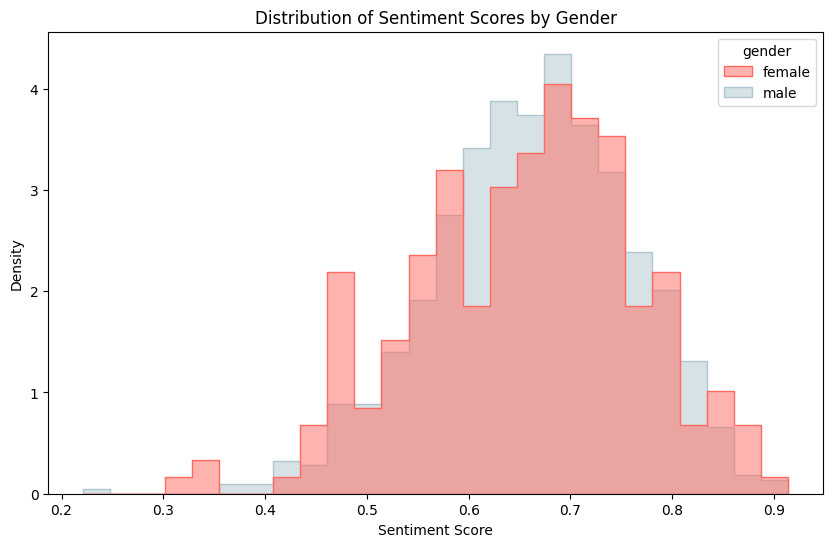

P-value: 0.1250228704914304


In [71]:
plt.figure(figsize=(10, 6))
palette = {'female': '#ff6961', 'male': '#aec6cf'}

# Create the histogram with specified colors
sns.histplot(data=df_master, x='sentiment', hue='gender', element="step", stat="density", common_norm=False, alpha=0.5, palette=palette)
plt.title('Sentiment Distribution by Gender')
plt.title('Distribution of Sentiment Scores by Gender')
plt.xlabel('Sentiment Score')
#plt.legend(title='Gender', labels=['Male', 'Female'], colors=['#aec6cf', '#ff6961'])
plt.ylabel('Density')
plt.show()

# Statistical significance test
male_scores = df_master[df_master['gender'] == 'male']['sentiment']
female_scores = df_master[df_master['gender'] == 'female']['sentiment']

# Use Mann-Whitney U test with alternative hypothesis that male scores are greater than female scores
u_statistic, p_value = ttest_ind(male_scores, female_scores, alternative='greater')

print(f'P-value: {p_value}')


In [66]:
df_master.to_excel("df_master.xlsx")

In [67]:
df_master =  pd.read_excel("df_master.xlsx")

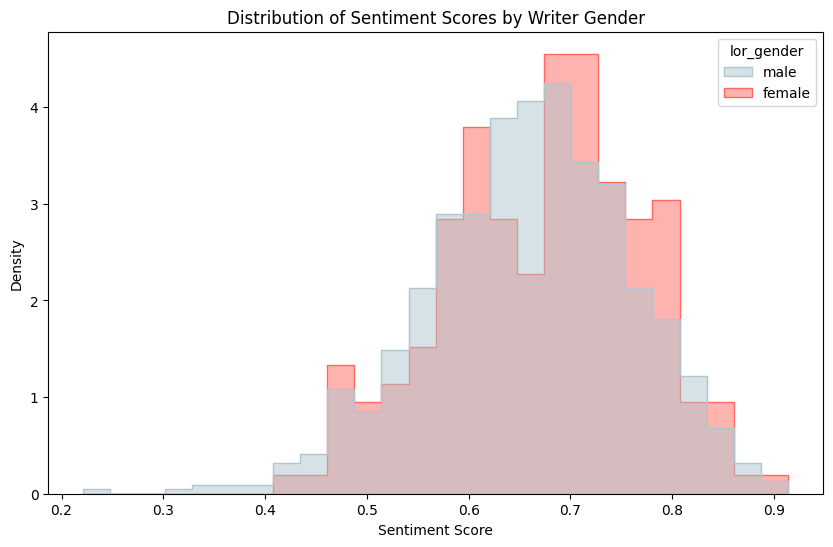

P-value: 0.9713328829809186


In [72]:
plt.figure(figsize=(10, 6))
palette = {'female': '#ff6961', 'male': '#aec6cf'}

# Create the histogram with specified colors
sns.histplot(data=df_master, x='sentiment', hue='lor_gender', element="step", stat="density", common_norm=False, alpha=0.5, palette=palette)
plt.title('Sentiment Distribution by Gender')
plt.title('Distribution of Sentiment Scores by Writer Gender')
plt.ylabel('Density')
plt.xlabel('Sentiment Score')
plt.show()

# Statistical significance test
male_scores = df_master[df_master['lor_gender'] == 'male']['sentiment']
female_scores = df_master[df_master['lor_gender'] == 'female']['sentiment']

# Use Mann-Whitney U test with alternative hypothesis that male scores are greater than female scores
u_statistic, p_value = ttest_ind(male_scores, female_scores, alternative='greater')

print(f'P-value: {p_value}')

In [83]:
m2m = df_master[(df_master['lor_gender'] == 'male') & (df_master['gender'] == 'male')]
f2m = df_master[(df_master['lor_gender'] == 'female') & (df_master['gender'] == 'male')]
f2f = df_master[(df_master['lor_gender'] == 'female') & (df_master['gender'] == 'female')]
m2f = df_master[(df_master['lor_gender'] == 'male') & (df_master['gender'] == 'female')]

# Use Mann-Whitney U test with alternative hypothesis that male scores are greater than female scores
t, p_value = ttest_ind(m2m['sentiment'], m2f['sentiment'], alternative='greater')

print(p_value, t)

t, p_value = ttest_ind(f2f['sentiment'], m2f['sentiment'], alternative='greater')

print(p_value, t)

print("Conclusion: Although there's no significant difference for letter sentiment between genders, \nwriters write more positively to the same gender")

0.0519074986422115 1.6284390516847986
0.0239817280754341 1.988841211325996
Conclusion: Although there's no significant difference for letter sentiment between genders, 
writers write more positively to the same gender
